In [ ]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 32.9 MB/s 
     |████████████████████████████████| 6.6 MB 45.6 MB/s 
     |████████████████████████████████| 120 kB 72.6 MB/s 


In [ ]:
from transformers import GPT2Tokenizer, GPT2Model, GPT2Config
from torch.nn import CosineSimilarity
import torch
import numpy as np

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# config = GPT2Config.from_pretrained('gpt2', output_hidden_states=True)
model = GPT2Model.from_pretrained('gpt2')

In [ ]:
# fetch ayrton's dataset
# orig_text: https://drive.google.com/file/d/12MOwMjTpejUsq4LFMqvzilH7Ec7aWssK/view?usp=sharing
# antonym_text: https://drive.google.com/file/d/1zfUPxs5vOdLjVhGBRk9UXPlAIQt9d3iQ/view?usp=sharing

file_id1 = "12MOwMjTpejUsq4LFMqvzilH7Ec7aWssK"
file_id2 = "1zfUPxs5vOdLjVhGBRk9UXPlAIQt9d3iQ"

!gdown "$file_id1"
!gdown "$file_id2"

Downloading...
From: https://drive.google.com/uc?id=12MOwMjTpejUsq4LFMqvzilH7Ec7aWssK
To: /content/cleaned_orig_txt.npy
100% 457k/457k [00:00<00:00, 137MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zfUPxs5vOdLjVhGBRk9UXPlAIQt9d3iQ
To: /content/cleaned_antonym_txt.npy
100% 460k/460k [00:00<00:00, 122MB/s]


In [ ]:
import numpy as np
antonym = np.load('cleaned_antonym_txt.npy')
original = np.load('cleaned_orig_txt.npy')

**Todos**:
- Try using a padding, as described in the paper in GPT's Embedding API page [(Link)](https://arxiv.org/pdf/2201.10005.pdf)
- Try each embedding method outlined below

## Fetch Antonyms in Each Sentence

In [ ]:
diff = []
for a, o in zip(antonym, original):
  a_split = a.split(" ")
  o_split = o.split(" ")
  word_parts = []
  for aa, oo in zip(a_split, o_split):
    if aa != oo:
      word_parts.append([aa, oo])
      if not aa.isalpha() or not oo.isalpha():
        print(aa, oo)
  diff.append(word_parts)

maximal-white minimal-white
opposite- alternate-
closed-lipless closed-lipped
high-floored high-ceilinged
pre-unpackaged pre-packaged
maximal-white minimal-white
sexual-that asexual-that
re-entrant salient
olive-skinless olive-skinned
machine-made handmade
pro-love anti-love
barely-unconcealed barely-concealed


In [ ]:
diff[:5]
# Commented to prevent execution
# for i, d in enumerate(diff):
#   if len(d) == 0:
#     print(i, d)
#     print(antonym[i], original[i], sep='\n')
#     print()
# np.save("sentence_diff.npy", np.array(diff, dtype="object"))
# np.load("sentence_diff.npy", allow_pickle=True)

[[['intelligent', 'unintelligent']],
 [['intended', 'unintended']],
 [['undesigned', 'designed']],
 [['moderating', 'intensifying']],
 [['interesting', 'uninteresting']]]

## Evaluating Embedding

I haven't found any references discussing how to get embeddings specifically from GPT, so I'm referencing BERT's method to get embeddings
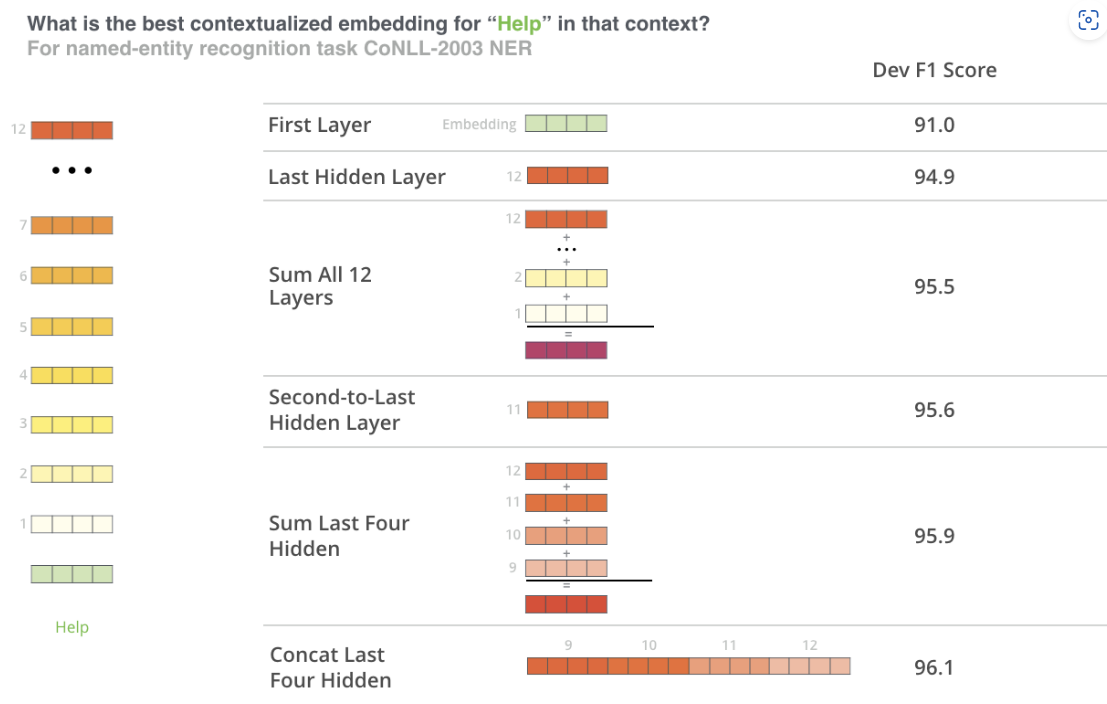 

In [ ]:
cossim = CosineSimilarity()

def util_enc_input(text, tokenizer):
  tokenizer.add_special_tokens({'pad_token': '[PAD]'})
  return tokenizer(text, padding=True, truncation=True, return_tensors='pt')

def util_postproc_tensor(tensor, dim=1, method='mean'):
  if method == "mean":
    return tensor.mean(dim=dim)
  if method == "sum":
    return tensor.sum(dim=dim)
  if method == "none":
    return tensor
  print("no correct method is passed")
  return None

def fetch_nth_last_layer(text, nth_layer, model=model, tokenizer=tokenizer, postproc_method="mean"):
  '''
  Fetch the hidden value of the final layer of the model for embedding.
  If there are >1 tokens on the final layer, average the hidden value of the tokens
  Params:
  - text: a word according to english lexicon
  - model: instance of transformers.model
  - tokenizer: tokenizer of the respective model
  '''
  enc_input = util_enc_input(text, tokenizer)
  return util_postproc_tensor(
      model(**enc_input, output_attentions=True, output_hidden_states=True).hidden_states[-nth_layer],
      method=postproc_method
  )

def fetch_sum_n_last_layers(text, n_layers, model=model, tokenizer=tokenizer, postproc_method="mean"):
  '''
  Fetch the sum of hidden value of the final N layers of the model for embedding.
  If there are >1 tokens on the final layer, average the hidden value of the tokens.
  *assumes there are >1 layers
  Params:
  - text: a word according to english lexicon
  - model: instance of transformers.model
  - tokenizer: tokenizer of the respective model
  '''
  enc_input = util_enc_input(text, tokenizer)
  hidden_states = model(**enc_input, output_attentions=True, output_hidden_states=True).hidden_states
  sum_last_four = hidden_states[-1]
  for i in range(2, n_layers+1):
    sum_last_four += hidden_states[-i]
  return util_postproc_tensor(
      sum_last_four,
      method=postproc_method
  )

def fetch_concat_n_last_layers(text, n_layers, model=model, tokenizer=tokenizer, postproc_method="mean"):
  '''
  Fetch the concatenation of the final N layers of the model for embedding.
  If there are >1 tokens on the final layer, average the hidden value of the tokens
  Params:
  - text: a word according to english lexicon
  - model: instance of transformers.model
  - tokenizer: tokenizer of the respective model
  '''
  enc_input = util_enc_input(text, tokenizer)
  hidden_states = model(**enc_input, output_attentions=True, output_hidden_states=True).hidden_states
  return util_postproc_tensor(
      torch.cat(hidden_states[-n_layers:], 2),
      method=postproc_method
  )

In [ ]:
test_data = [
    ("male", "boy"),
    ("male", "male"),
    ("male", "female"),
    ("male", "toilet"),
    (antonym[0], original[0])
]
print("last_layer:")
for w1, w2 in test_data:
  print(f"cos_sim({w1}, {w2}) = {torch.norm(fetch_nth_last_layer(w1, 1)-fetch_nth_last_layer(w2, 1))}")

print("\n2nd last_layer:")
for w1, w2 in test_data:
  print(f"cos_sim({w1}, {w2}) = {torch.norm(fetch_nth_last_layer(w1, 2)-fetch_nth_last_layer(w2, 2))}")
  
print("\nsum_last_four:")
for w1, w2 in test_data:
  print(f"cos_sim({w1}, {w2}) = {torch.norm(fetch_sum_n_last_layers(w1, 4)-fetch_sum_n_last_layers(w2, 4))}")

print("\nconcat_last_four:")
for w1, w2 in test_data:
  print(f"cos_sim({w1}, {w2}) = {torch.norm(fetch_concat_n_last_layers(w1, 4)-fetch_concat_n_last_layers(w2, 4))}")

print("\nsum_all_twelve:")
for w1, w2 in test_data:
  print(f"cos_sim({w1}, {w2}) = {torch.norm(fetch_sum_n_last_layers(w1, 12)-fetch_sum_n_last_layers(w2, 12))}")

last_layer:
cos_sim(male, boy) = 6.0633158683776855
cos_sim(male, male) = 0.0
cos_sim(male, female) = 3.137962818145752
cos_sim(male, toilet) = 51.34971618652344
cos_sim(`` well said , '' mr. meyers replied , the first time he revealed that he was fully aware of all the intelligent comments gary had mouthed during the dinner ., `` well said , '' mr. meyers replied , the first time he revealed that he was fully aware of all the unintelligent comments gary had mouthed during the dinner .) = 1.491457462310791

2nd last_layer:
cos_sim(male, boy) = 36.61703872680664
cos_sim(male, male) = 0.0
cos_sim(male, female) = 22.4443416595459
cos_sim(male, toilet) = 1513.3831787109375
cos_sim(`` well said , '' mr. meyers replied , the first time he revealed that he was fully aware of all the intelligent comments gary had mouthed during the dinner ., `` well said , '' mr. meyers replied , the first time he revealed that he was fully aware of all the unintelligent comments gary had mouthed during the di